In [1]:
ultrasound_size = 128

data_folder = r"QueensToChildrens"
notebook_save_folder = r"SavedNotebooks"
model_save_folder = r"SavedModels"

ultrasound_file = r"ultrasound.npy"
segmentation_file = r"segmentation.npy"

test_ultrasound_file = r"ultrasound-test.npy"
test_segmentation_file = r"segmentation-test.npy"
test_prediction_file=r"prediction-test.npy"

In [2]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

from local_vars import root_folder

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)

ultrasound_fullname = os.path.join(data_fullpath, ultrasound_file)
segmentation_fullname = os.path.join(data_fullpath, segmentation_file)

print("Reading ultrasound images from:  {}".format(ultrasound_fullname))
print("Reading segmentations from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))

Reading ultrasound images from:  j:\Data\QueensToChildrens\ultrasound.npy
Reading segmentations from:      j:\Data\QueensToChildrens\segmentation.npy

Found 3290 ultrasound images and 3290 segmentations


In [4]:
test_ultrasound_fullname = os.path.join(data_fullpath, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_fullpath, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: j:\Data\QueensToChildrens\ultrasound-test.npy
Reading test segmentation from : j:\Data\QueensToChildrens\segmentation-test.npy

Found 795 test ultrasound images and 795 segmentations


In [5]:
import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i,:,:] = np.flip(self.y[batch_indexes[i],:,:], axis=1)
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
                y[i,:,:] = self.y[batch_indexes[i],:,:]
        
        angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
        
        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

In [6]:
# Prepare dilated output

def dialateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 1
segmentation_dilated = dialateStack(segmentation_data[:, :, :, 0], width)

In [7]:
# Uncomment this if you don't want dilation

segmentation_dilated[:, :, :] = segmentation_data[:, :, :, 0]

In [8]:
# Testing batch generator

batch_size = 4
num_show = 2

tgen = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size, shuffle=False)

bx, by = tgen.__getitem__(0)

import matplotlib.pyplot as plt

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show,3,i*3+1)
    img1 = a1.imshow(bx[i, :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Ultrasound #{}".format(i))
    c = fig.colorbar(img1)
    a2 = fig.add_subplot(num_show,3,i*3+2)
    img2 = a2.imshow(by[i, :, :, 0], vmin=0.0, vmax=1.0)
    a2.set_title("Class 0 #{}".format(i))
    c = fig.colorbar(img2)
    a3 = fig.add_subplot(num_show,3,i*3+3)
    img3 = a3.imshow(by[i, :, :, 1], vmin=0.0, vmax=1.0)
    a3.set_title("Class 1 #{}".format(i))
    c = fig.colorbar(img3)

In [9]:
# Construct a U-net model

num_classes = 2
filter_multiplier = 8

def nvidia_unet(patch_size=ultrasound_size, num_classes=num_classes):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    
    num_layers = int(np.floor(np.log2(patch_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    print("Number of layers:       {}".format(num_layers))
    print("Filters in layers down: {}".format(down_filter_numbers))
    print("Filters in layers up:   {}".format(up_filter_numbers))
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
    
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != num_classes:
            activation = "relu"
            output = Conv2D(filters, (shape, shape), activation="relu", padding="same")(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            activation = "softmax"
            output = Conv2D(filters, (shape, shape), activation="softmax", padding="same")(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet(ultrasound_size, num_classes)

# model.summary()

Number of layers:       7
Filters in layers down: [10 18 26 34 42 50 58]
Filters in layers up:   [50 42 34 26 18 10  2]
Instructions for updating:
Colocations handled automatically by placer.


In [10]:
print("Model built with {} parameters".format(model.count_params()))

Model built with 304902 parameters


In [11]:
max_learning_rate = 0.002
min_learning_rate = 0.0000001
num_epochs = 100

learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
               loss= "binary_crossentropy",
               metrics=["accuracy"])

print("Learning rate decay = {}".format(learning_rate_decay))


Learning rate decay = 1.9999000000000003e-05


In [12]:
batch_size = 24

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = model.fit_generator(training_generator,
                                   validation_data=test_generator,
                                   epochs=num_epochs,
                                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
137/137 [==============================] - 12s 88ms/step - loss: 0.1540 - acc: 0.9768 - val_loss: 0.0263 - val_acc: 0.9965
Epoch 2/100
137/137 [==============================] - 8s 59ms/step - loss: 0.0147 - acc: 0.9966 - val_loss: 0.0166 - val_acc: 0.9964
Epoch 3/100
137/137 [==============================] - 10s 70ms/step - loss: 0.0116 - acc: 0.9966 - val_loss: 0.0124 - val_acc: 0.9969
Epoch 4/100
137/137 [==============================] - 9s 67ms/step - loss: 0.0104 - acc: 0.9967 - val_loss: 0.0098 - val_acc: 0.9971
Epoch 5/100
137/137 [==============================] - 8s 61ms/step - loss: 0.0099 - acc: 0.9968 - val_loss: 0.0119 - val_acc: 0.9964
Epoch 6/100
137/137 [==============================] - 8s 59ms/step - loss: 0.0095 - acc: 0.9968 - val_loss: 0.0097 - val_acc: 0.9971
Epoch 7/100
137/137 [==============================] - 8s 62ms/step 

Epoch 58/100
137/137 [==============================] - 9s 66ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0095 - val_acc: 0.9974
Epoch 59/100
137/137 [==============================] - 9s 65ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0094 - val_acc: 0.9974
Epoch 60/100
137/137 [==============================] - 9s 66ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0093 - val_acc: 0.9973
Epoch 61/100
137/137 [==============================] - 9s 66ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0102 - val_acc: 0.9973
Epoch 62/100
137/137 [==============================] - 9s 66ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0092 - val_acc: 0.9974
Epoch 63/100
137/137 [==============================] - 9s 66ms/step - loss: 0.0066 - acc: 0.9973 - val_loss: 0.0089 - val_acc: 0.9973
Epoch 64/100
137/137 [==============================] - 9s 65ms/step - loss: 0.0066 - acc: 0.9973 - val_loss: 0.0089 - val_acc: 0.9973
Epoch 65/100
137/137 [==============================] -

In [13]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-07-24 21:47:58.390260
Training stopped at: 2019-07-24 22:03:06.974385
Total training time: 0:15:08.584125


In [14]:
y_pred = model.predict(test_ultrasound_data)

In [15]:
# Saving prediction for further evaluation

test_prediction_fullname = os.path.join(data_fullpath, test_prediction_file)
np.save(test_prediction_fullname, y_pred)

print("Predictions saved to: {}".format(test_prediction_fullname))

Predictions saved to: j:\Data\QueensToChildrens\prediction-test.npy


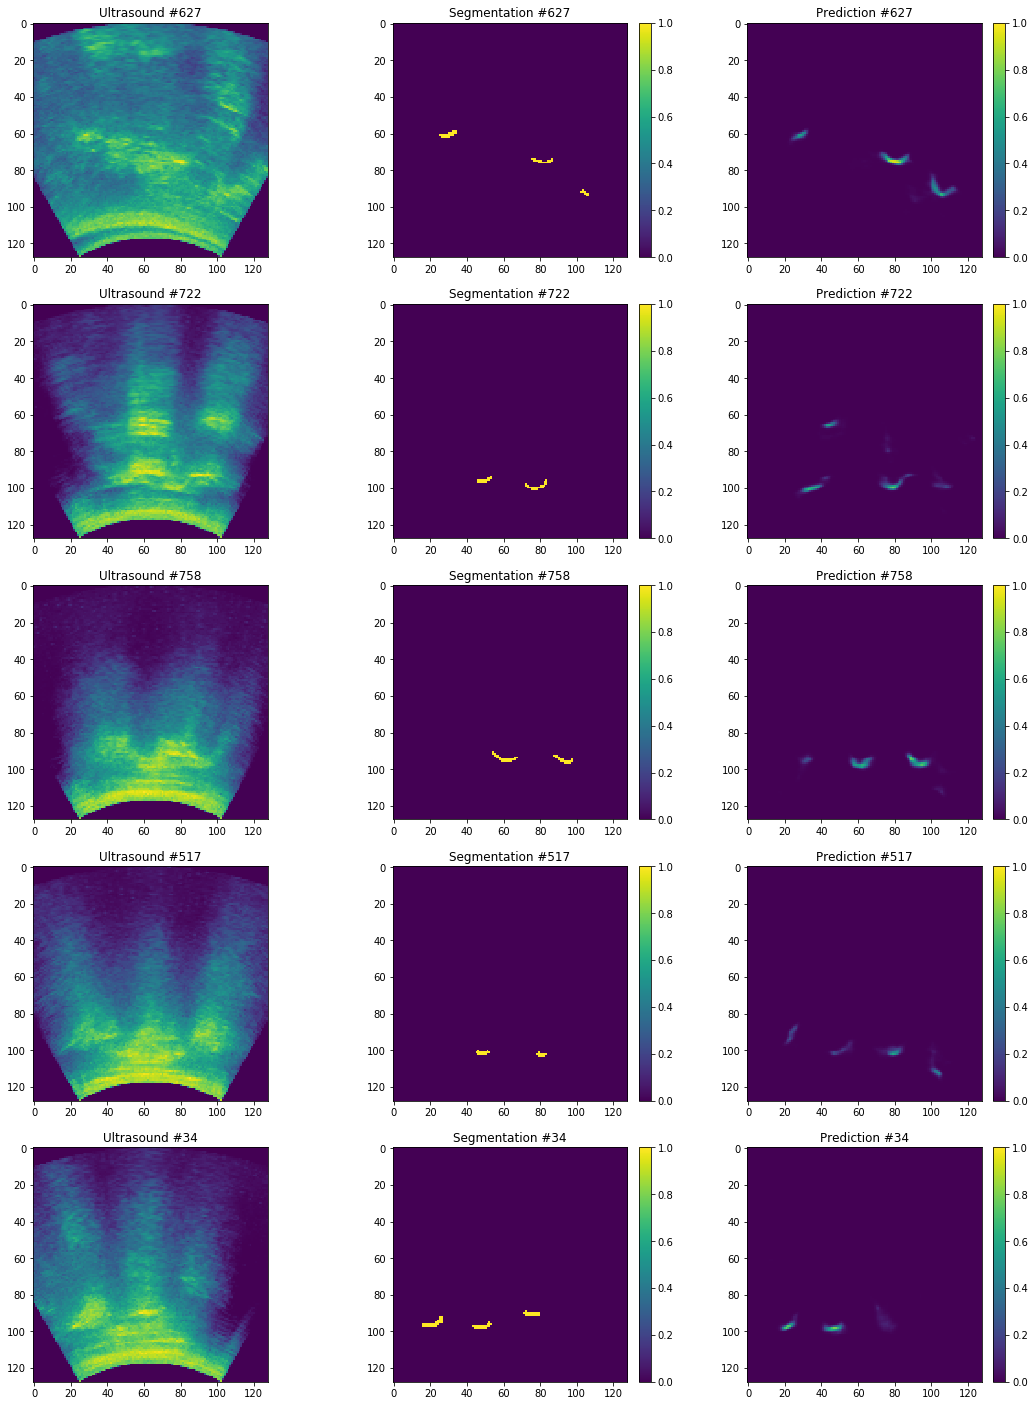

In [16]:
from random import sample

num_test = test_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_data[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(y_pred[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

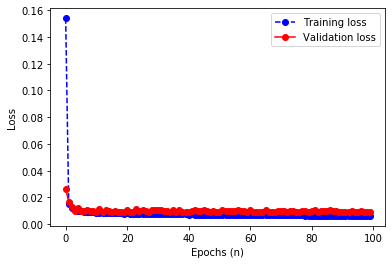

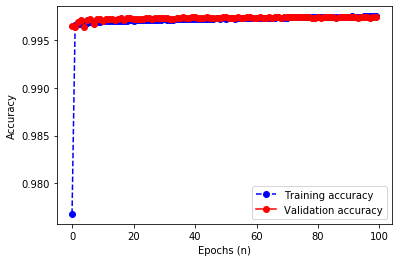

In [17]:
# Display training loss and accuracy curves over epochs

plt.plot(training_log.history['loss'], 'bo--')
plt.plot(training_log.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()
plt.plot(training_log.history['acc'], 'bo--')
plt.plot(training_log.history['val_acc'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [18]:
import time

time.sleep(3)

In [19]:
# Archive model and notebook with unique filenames based on timestamps

import datetime


timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_fullpath = os.path.join(root_folder, model_save_folder)
if not os.path.exists(saved_models_fullpath):
    os.makedirs(saved_models_fullpath)
    print("Creating folder: {}".format(saved_models_fullpath))

model_file_name = "model_" + timestamp + ".h5"
model_fullname = os.path.join(saved_models_fullpath, model_file_name)
model.save(model_fullname)

print("Model saved to: {}".format(model_fullname))

saved_notebooks_fullpath = os.path.join(root_folder, notebook_save_folder)
if not os.path.exists(saved_notebooks_fullpath):
    os.makedirs(saved_notebooks_fullpath)
    print("Creating folder: {}".format(saved_notebooks_fullpath))

notebook_file_name = "notebook_" + timestamp + ".html"
notebook_fullname = os.path.join(saved_notebooks_fullpath, notebook_file_name)

Model saved to: j:\Data\SavedModels\model_2019-07-24_22-03-14.h5


In [20]:
time.sleep(30)

In [22]:
# If figures are missing from the saved notebook, run this cell again after some time has passed

os.system("jupyter nbconvert --to html Segmentation2.ipynb --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: j:\Data\SavedNotebooks\notebook_2019-07-24_22-03-14.html
